# Analyse results of hyperparameter search

In [80]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance

from model_functions import select_variables
from model_functions import train_xgb_model
from model_functions import train_xgb_model_no_plot
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction_subplot

## Get data

In [54]:
# Type of features used in training
#feature_scope = 'temp_prec' # Temperature and precipitation
feature_scope = 'all_climate' # All climate data

# Path of cv results
#training_path = '2023-09-18_12-21-53/temp_prec_' # 5 fold blocking by glacier, grid search with ~800 000 hyperparameter comb., temperature + precipitation + topographical features
training_path = '2023-09-26_20-18-23/all_climate_' # 5 fold blocking by glacier, grid search with ~800 000 hyperparameter comb., all climate + topographical features

In [55]:
# Specify filepaths and filenames.
loc = 'cluster'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'
elif loc == 'cluster':
    filepath = '/mirror/khsjursen/ML_MB_Norway/Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)

/tmp/ipykernel_20800/2984070557.py:14: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [94]:
# Get features and labels based on type of features used in training

# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

if feature_scope=='temp_prec':
    
    # Select features
    base_cols = ['altitude','aspect','slope','altitude_climate','lat','lon']
    temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
    prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
    label_cols = ['balance_netto']

    # Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
    df_train_s = df_train.sample(frac=1, random_state=5)
    df_train_s.reset_index(drop=True, inplace=True)

    # Select features for training
    df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)

    # Select labels for training
    df_train_y_s = select_variables(df_train_s, label_cols)
    X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

    
elif feature_scope=='all_climate':

    # Select features to drop
    cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

    snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
    snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
    evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
    snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
    snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
    snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
    snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
    snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
    snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

    drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

    # Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
    df_train_s = df_train.sample(frac=1, random_state=5)
    df_train_s.reset_index(drop=True, inplace=True)

    # Select features for training
    df_train_X_s = df_train_s.drop(drop_cols, axis=1)

    # Select labels for training
    df_train_y_s = df_train_s[['balance_netto']]
    X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [95]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [79]:
print('Train, fold 1: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 5: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 5: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 1:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 1:  [2297]
Train, fold 2:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 2:  [2078]
Train, fold 3:  [ 596  675 1144 2078 2148 2297 2474 2514 2597 2743 3126 3128 3129 3137]
Validation, fold 3:  [1092 1094 2772 2968 3133 3138]
Train, fold 4:  [ 596 1092 1094 1144 2078 2148 2297 2514 2772 2968 3126 3128 3133 3138]
Validation, fold 4:  [ 675 2474 2597 2743 3129 3137]
Train, fold 5:  [ 675 1092 1094 2078 2297 2474 2597 2743 2772 2968 3129 3133 3137 3138]
Validation, fold 5:  [ 596 1144 2148 2514 3126 3128]


## Get grid search results

In [37]:
# Specify filepaths and filenames.
if loc == 'cryocloud':
    filepath_results = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath_results = 'Models/Block_glacier_5fold/'
elif loc == 'cluster':
    filepath_results = '/mirror/khsjursen/ML_MB_Norway/Models/Block_glacier_5fold/'    

In [38]:
# Get cv-grid
cv_grid = joblib.load(filepath_results + training_path + 'cv_grid.pkl')

# Get cv-scores
cv_scores = joblib.load(filepath_results + training_path + 'cv_scores.pkl')

# Get best model
best_model = joblib.load(filepath_results + training_path + 'cv_best_model.pkl')

In [39]:
cv_grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_colsample_bytree', 'param_gamma', 'param_lambda', 'param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_n_estimators', 'param_random_state', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [40]:
print('Best mean validation score: ', cv_grid.cv_results_['mean_test_score'].max())
print('Validation score per fold: ', cv_scores)
print('Check mean score: ', cv_scores.mean())
print('Standard deviation: ', cv_scores.std())

Best mean validation score:  -1.7126838934389745
Validation score per fold:  [-1.87950467 -1.51111191 -2.03573566 -1.30444448 -1.83262275]
Check mean score:  -1.7126838934389745
Standard deviation:  0.26603294125887506


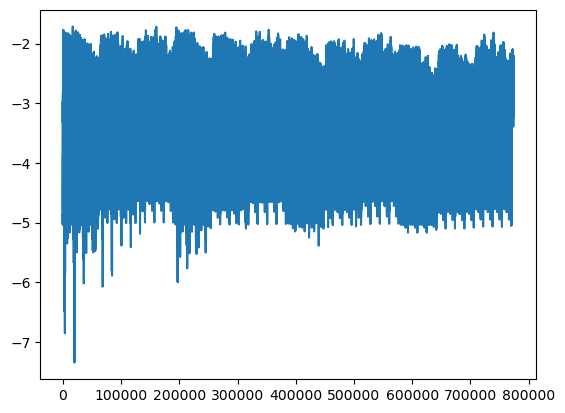

In [41]:
plt.plot(cv_grid.cv_results_['mean_test_score'])

In [42]:
cv_grid.best_params_

{'alpha': 0,
 'colsample_bytree': 0.5,
 'gamma': 1,
 'lambda': 0,
 'learning_rate': 0.15,
 'max_depth': 2,
 'min_child_weight': 0,
 'n_estimators': 500,
 'random_state': 23,
 'subsample': 0.5}

In [43]:
idx = np.argmin(cv_grid.cv_results_['rank_test_score'])
idx

17151

In [44]:
print('Validation score fold 0: ', cv_grid.cv_results_['split0_test_score'][idx])
print('Validation score fold 1: ', cv_grid.cv_results_['split1_test_score'][idx])
print('Validation score fold 2: ', cv_grid.cv_results_['split2_test_score'][idx])
print('Validation score fold 3: ', cv_grid.cv_results_['split3_test_score'][idx])
print('Validation score fold 4: ', cv_grid.cv_results_['split4_test_score'][idx])

Validation score fold 0:  -1.8795046653109124
Validation score fold 1:  -1.5111119124988825
Validation score fold 2:  -2.035735659120896
Validation score fold 3:  -1.3044444758589397
Validation score fold 4:  -1.8326227544052405


In [45]:
cv_grid.cv_results_['params'][idx]

{'alpha': 0,
 'colsample_bytree': 0.5,
 'gamma': 1,
 'lambda': 0,
 'learning_rate': 0.15,
 'max_depth': 2,
 'min_child_weight': 0,
 'n_estimators': 500,
 'random_state': 23,
 'subsample': 0.5}

In [46]:
best_model

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0, learning_rate=0.15,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None, ...)

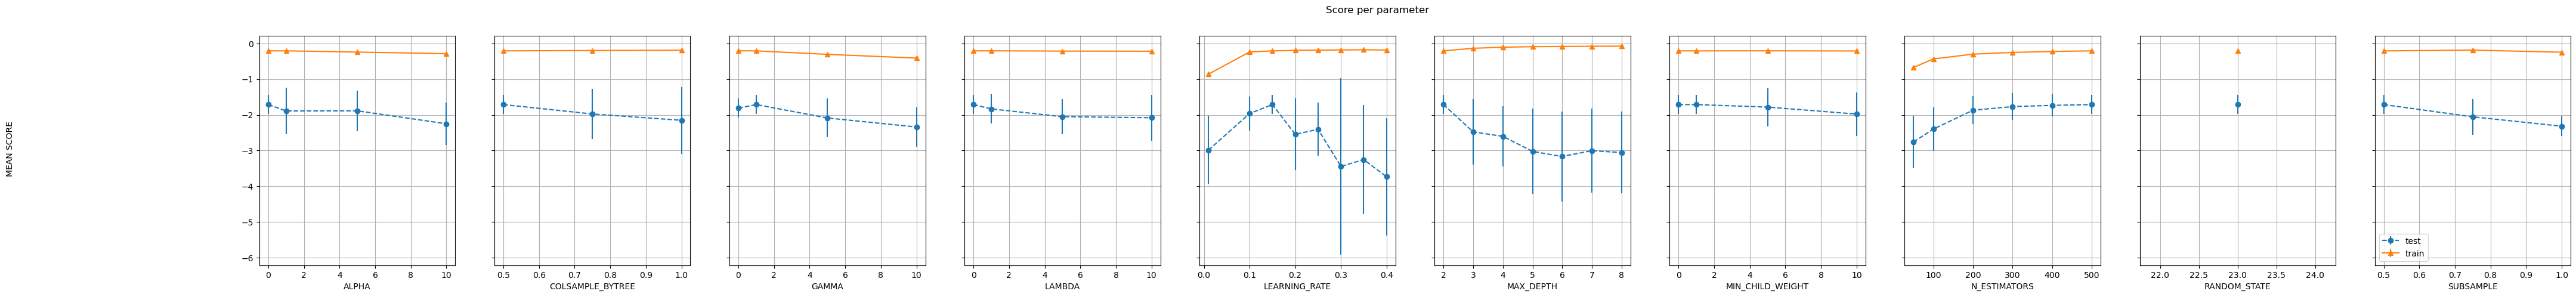

In [47]:
plot_gsearch_results(cv_grid)

min_child_weight parameter: "
Intuitively, this is the minimum number of samples that a node can represent in order to be split further. If there are fewer than min_child_weight samples at that node, the node becomes a leaf and is no longer split. This can help reduce the model complexity and prevent overfittin"

large min child weight with shallow trees??g.

In [172]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [66]:
from sklearn.model_selection import cross_val_score
cvl = cross_val_score(fitted_model, X_train_s, y_train_s, cv=splits_s, scoring='neg_mean_squared_error')
print(cvl)

[-1.3754247  -3.07240161 -1.80111895 -1.03138146 -2.15455894]


In [115]:
#param_ranges = {'max_depth': [2], # Depth of tree
#                'n_estimators': [400], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.15], #[0,1]
#                'gamma': [0], # Regularization parameter [0,inf]
#                'lambda': [5], # Regularization [1,inf]
#                'alpha': [1], # Regularization [0,inf]
#                'colsample_bytree': [0.5], # (0,1]  A smaller colsample_bytree value results in smaller and less complex models, which can help prevent overfitting. It is common to set this value between 0.5 and 1.
#                'subsample': [0.5], # (0,1] common to set this value between 0.5 and 1
#                'min_child_weight': [10], # [0,inf]
#                'random_state': [0, 1, 2, 3, 4]
#               } 

#cv_grid_test, best_model_test, cvl_scores_test = train_xgb_model_no_plot(X_train_s, y_train_s, splits_s, param_ranges, n_jobs=40, scorer='neg_mean_squared_error')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [114]:
#print('Best mean validation score: ', cv_grid_test.cv_results_['mean_test_score'].max())
#print('Validation score per fold: ', cvl_scores_test)
#print('Check mean score: ', cvl_scores_test.mean())
#print('Standard deviation: ', cvl_scores_test.std())

Best mean validation score:  -1.9429728548317737
Validation score per fold:  [-1.74773446 -1.87597451 -2.32057812 -1.29174879 -2.4788284 ]
Check mean score:  -1.9429728548317737
Standard deviation:  0.4234209450016131


In [67]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.4)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

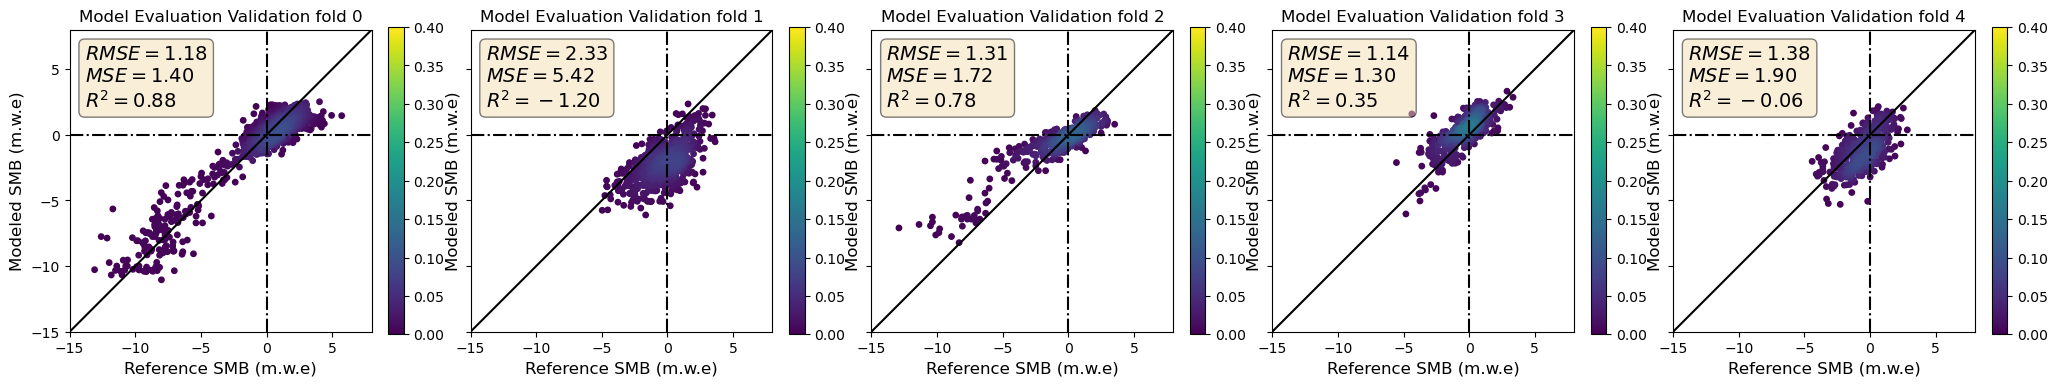

In [76]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    fitted_model.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

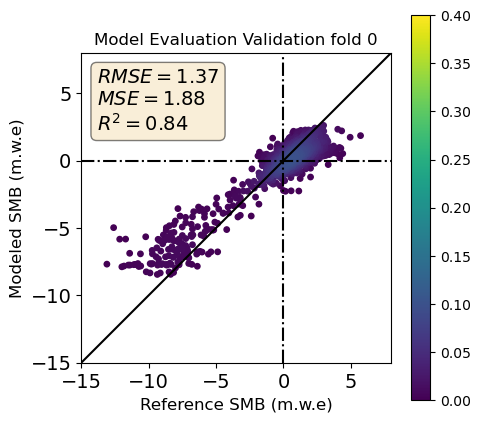

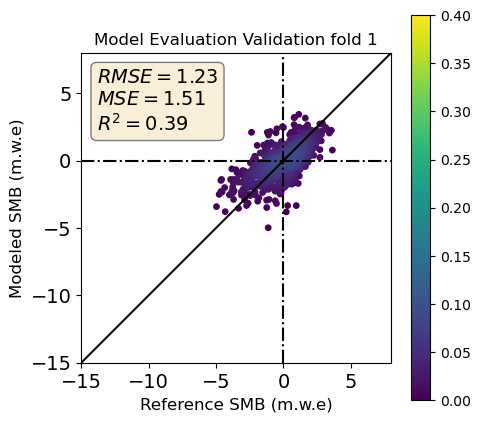

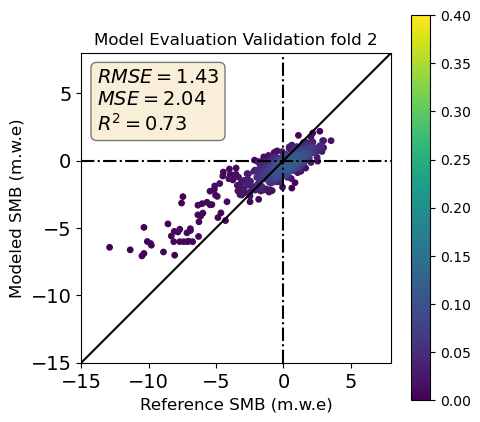

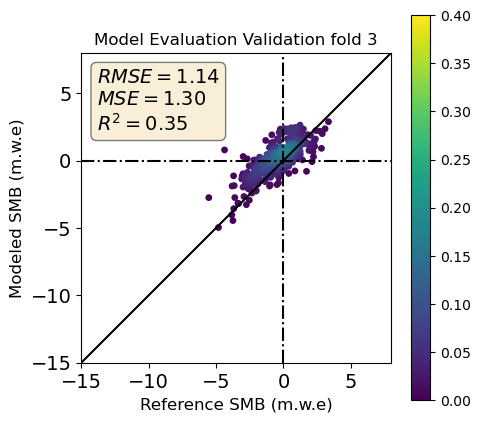

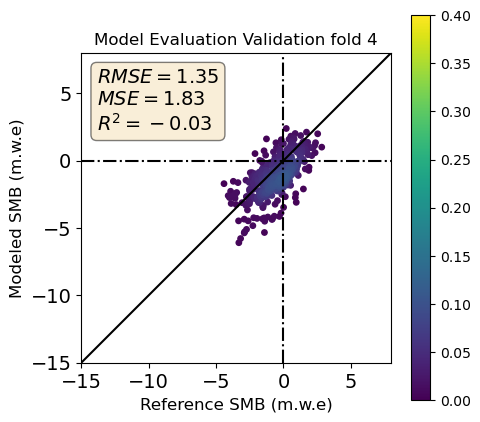

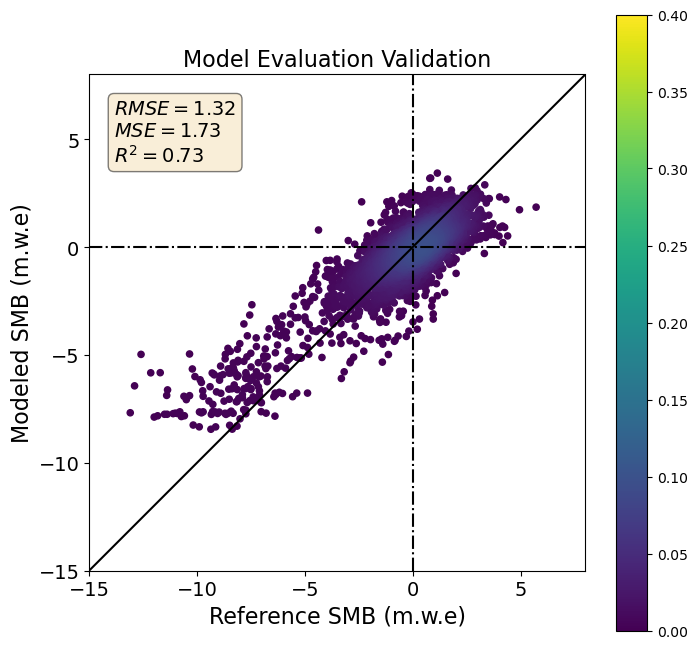

In [62]:
%matplotlib inline
plot_prediction_per_fold(X_train_s, y_train_s, fitted_model, splits_s)


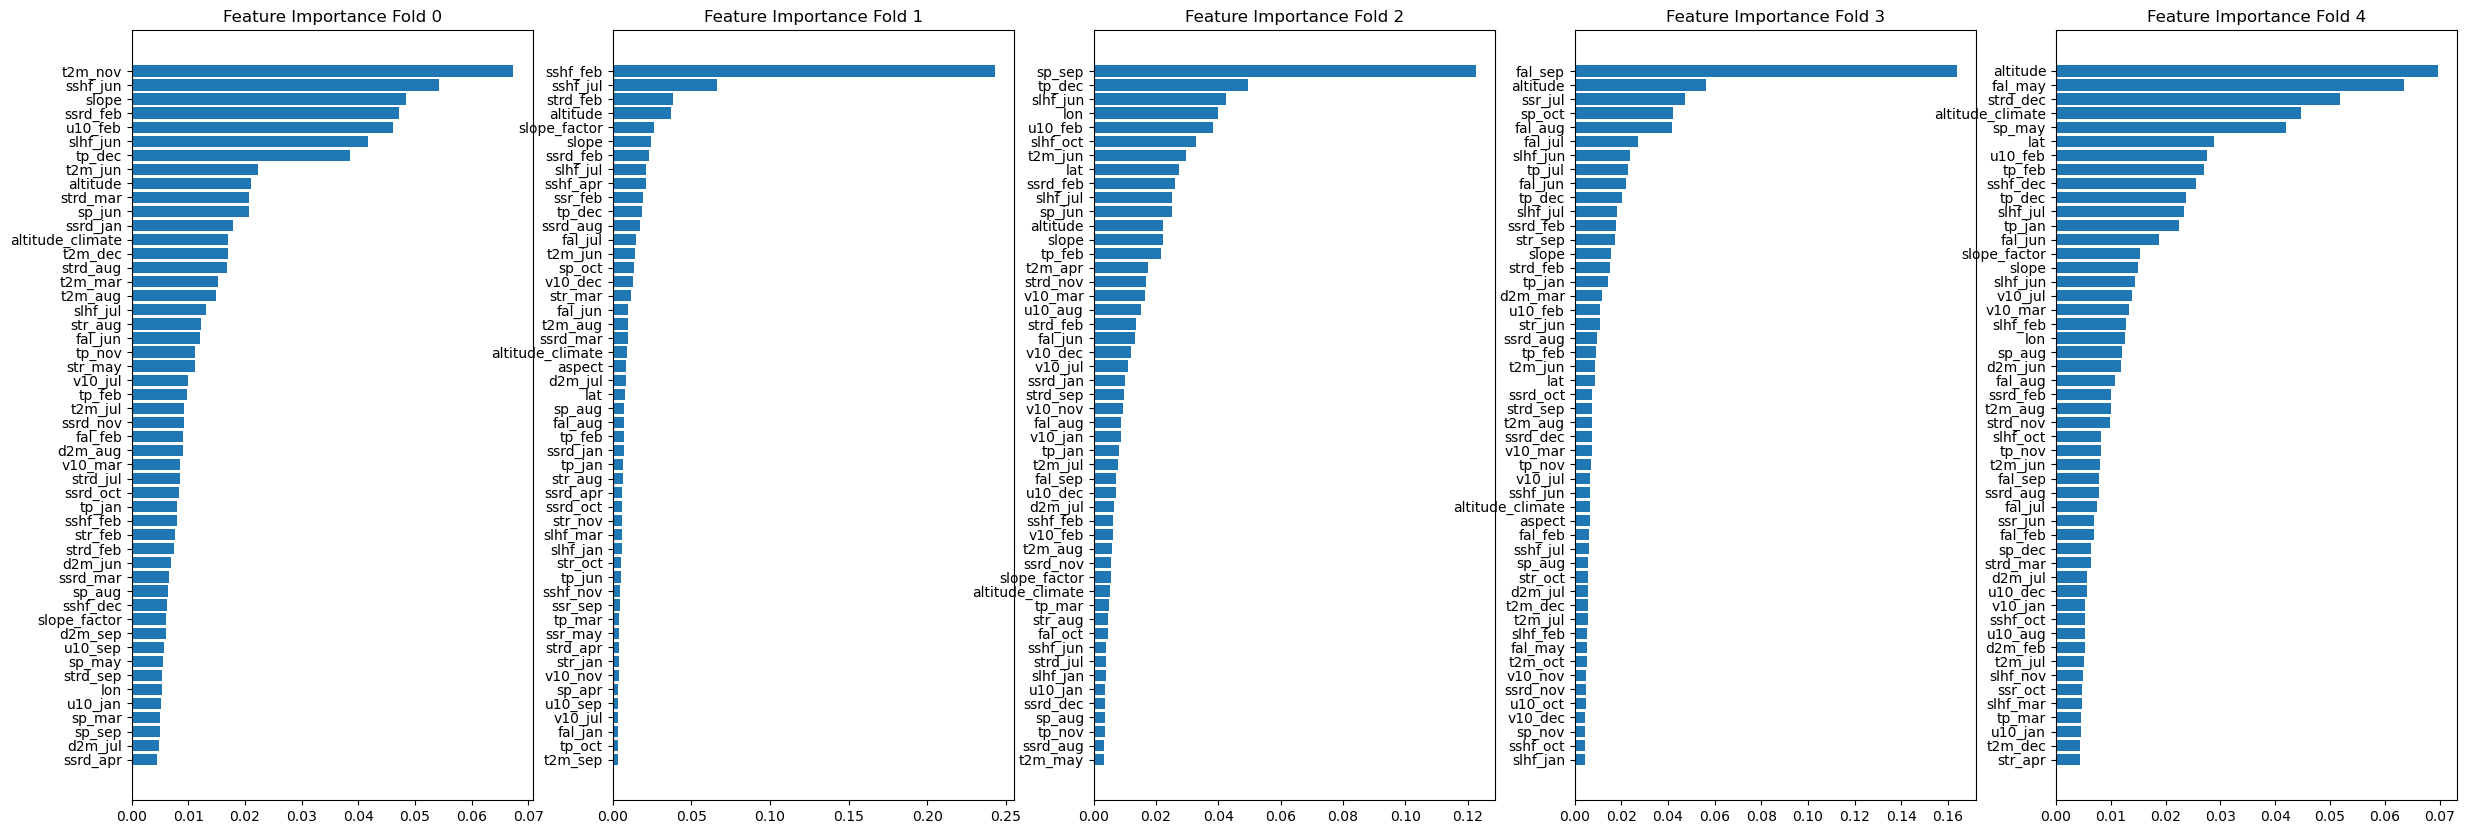

In [131]:
max_features_plot = 50

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    
    fitted_model.fit(X_train, y_train)
    feature_importance = fitted_model.feature_importances_
    ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
    feature_importance_50 = feature_importance[ind]
    sorted_idx = np.argsort(feature_importance_50)
    y_cols = np.array(df_train_X_s.columns)[ind]

    pos = np.arange(sorted_idx.shape[0]) + 0.5

    ax[a].barh(pos, feature_importance_50[sorted_idx], align="center")
    ax[a].set_yticks(pos)
    ax[a].set_yticklabels(y_cols[sorted_idx])
    ax[a].set_title("Feature Importance Fold " + str(a))

    a=a+1

fig.show()

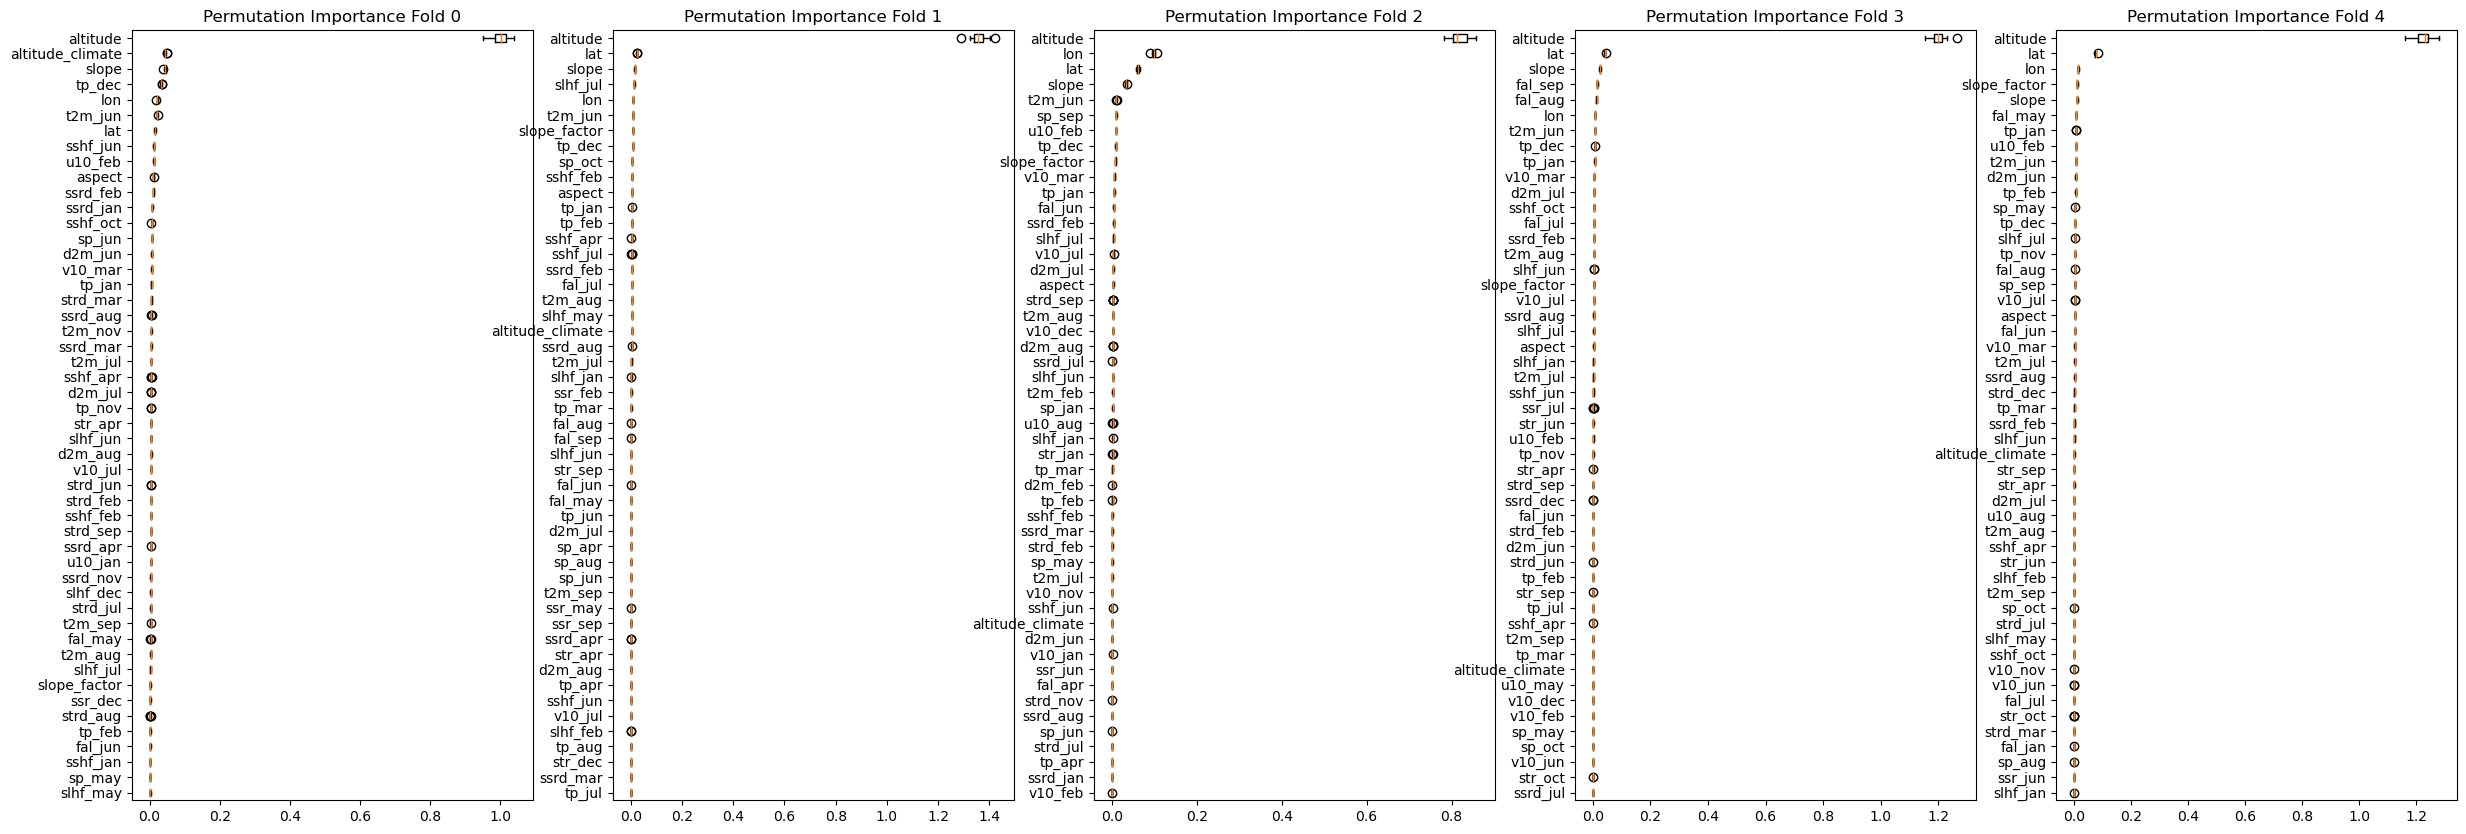

In [173]:
# Plot permutation importance

max_features_plot = 50

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]

    fitted_model.fit(X_train, y_train)
    
    result = permutation_importance(fitted_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

    sorted_idx = result.importances_mean.argsort()
    labels = np.array(df_train_X_s.columns)[sorted_idx][-max_features_plot:]
    
    ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
    ax[a].set_title("Permutation Importance Fold " + str(a))

    a=a+1

fig.show()

In [171]:
df_train_X_s

,altitude,lat,lon,aspect,slope,slope_factor,u10_oct,u10_nov,u10_dec,u10_jan,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,1003.0,68.340561,17.858938,0.771427,0.162549,2.974466,0.005267,-0.816228,0.717362,1.935894,...,0.012715,0.002994,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943
1,1835.0,61.685867,7.067199,1.122083,0.084707,3.872423,-0.749103,-0.378345,-0.336642,-0.478604,...,0.008896,0.008417,0.001199,0.001869,0.001849,0.004311,0.001448,0.006092,0.005234,1382.210502
2,1714.0,61.682190,7.094401,1.237335,0.054599,3.872423,-0.510595,0.046399,-0.422904,-0.613996,...,0.004952,0.003765,0.004185,0.001821,0.000777,0.004347,0.002090,0.004416,0.005844,1382.210502
3,1513.0,61.699908,7.125761,2.613254,0.095680,3.872423,-0.211532,-0.735964,-0.570865,-0.743390,...,0.005657,0.002251,0.003153,0.003520,0.001913,0.002004,0.007230,0.002486,0.009946,1382.210502
4,1513.0,61.672016,7.158100,2.489397,0.100789,3.872423,-0.851933,-0.991038,-0.681692,-0.727109,...,0.001720,0.004909,0.002112,0.004616,0.003036,0.004256,0.005699,0.006093,0.002317,1322.716089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,1202.0,61.758950,5.625995,0.515098,0.163740,2.961468,-0.924199,-1.175275,-1.076444,-0.895635,...,0.004461,0.008222,0.016302,0.006205,0.003339,0.007164,0.008963,0.006549,0.003427,653.949191
2805,1683.0,61.715591,7.080002,2.061907,0.035220,3.872423,-0.308935,0.048113,-0.314648,-1.042453,...,0.001895,0.004561,0.008560,0.004505,0.002596,0.003751,0.006537,0.005420,0.004903,1382.210502
2806,494.0,61.680847,7.198228,2.314971,0.246883,2.314757,0.050969,-0.336356,-0.613139,-0.733393,...,0.001409,0.001630,0.003193,0.002061,0.002845,0.003021,0.007638,0.003628,0.005945,1322.716089
2807,1434.0,61.715034,7.164559,2.620737,0.084480,3.872423,-0.198107,-0.901919,-0.593430,-0.376917,...,0.007489,0.000399,0.009600,0.005047,0.001893,0.006551,0.004973,0.004753,0.003119,1322.716089
